## Build and Train Model

#### *About the Dataset:*
- *Chest X-ray exams are one of the most frequent and cost-effective medical imaging examinations available. However, clinical diagnosis of a chest X-ray can be challenging and sometimes more difficult than diagnosis via chest CT imaging* The **National Institutes of Health Chest X-Ray Dataset Chest** can be found [Here](https://www.kaggle.com/nih-chest-xrays/data) on Kaggle


- *This NIH Chest X-ray Dataset is comprised of 112,120 X-ray images with disease labels from 30,805 unique patients with about **42 GB** in size and might require **GPU**. To create these labels, the authors used Natural Language Processing to text-mine disease classifications from the associated radiological reports. The labels are expected to be >90% accurate and suitable for weakly-supervised learning. The original radiology reports are not publicly available but you can find more details on the labeling process in this Open Access paper: "ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases." (Wang et al.)*

### Import libraries

In [1]:
import sys
import numpy as np 
import pandas as pd 
import os
from glob import glob # for DCM files
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
from random import sample 
import scipy
import seaborn as sns
import tensorflow as tf

#To read DICOM images
import sklearn.model_selection as skl
from sklearn.preprocessing import binarize
from skimage import io
from keras.preprocessing.image import ImageDataGenerator

#Import library for traning and validation set
from keras.models import load_model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

#Import matrix to evaluate model
from sklearn.metrics import roc_curve,roc_auc_score,auc
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,precision_recall_curve,plot_precision_recall_curve

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

##### Read all of your full image filepaths into a dataframe for easier manipulation

- **Load the NIH data to all_xray_df**

In [2]:
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
24118,00006332_007.png,No Finding,7,6332,47,F,AP,2500,2048,0.171,0.171,NaN,/data/images_003/images/00006332_007.png
63419,00015647_029.png,Effusion|Infiltration,29,15647,45,F,AP,3056,2544,0.139,0.139,NaN,/data/images_007/images/00015647_029.png
49060,00012432_000.png,Nodule,0,12432,45,F,PA,2992,2841,0.143,0.143,NaN,/data/images_006/images/00012432_000.png


#### Changing the column names to more friendly strings

In [3]:
all_xray_df.columns = all_xray_df.columns.str.replace('\.*\s+', '_').str.lower()

**Create some extra columns in your table with binary indicators of certain diseases rather than working directly with the finding Labels column**

In [4]:
all_labels = np.unique(list(chain(*all_xray_df['finding_labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))

for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['finding_labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(5)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,image_index,finding_labels,follow-up_#,patient_id,patient_age,patient_gender,view_position,originalimage[width,height],originalimagepixelspacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
40608,00010544_032.png,No Finding,32,10544,33,F,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
70416,00017362_012.png,No Finding,12,17362,52,F,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
33440,00008760_010.png,Effusion,10,8760,67,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30116,00007857_005.png,No Finding,5,7857,53,F,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
72809,00017946_000.png,Fibrosis,0,17946,77,M,PA,2021,2021,0.194311,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Plot to see the label we have in our dataset 

#### Here we can create a new column called 'pneumonia_class' that will allow us to look at images with or without pneumonia for binary classification

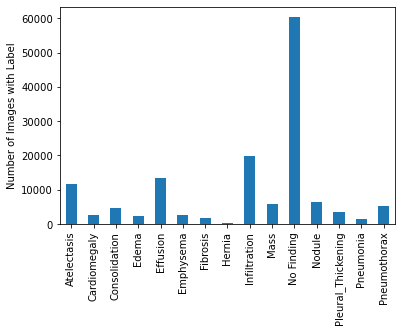

In [5]:
ax = all_xray_df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')
pass

#### Since there are many combinations of potential findings, I'm going to look at the 30 most common co-occurrences:

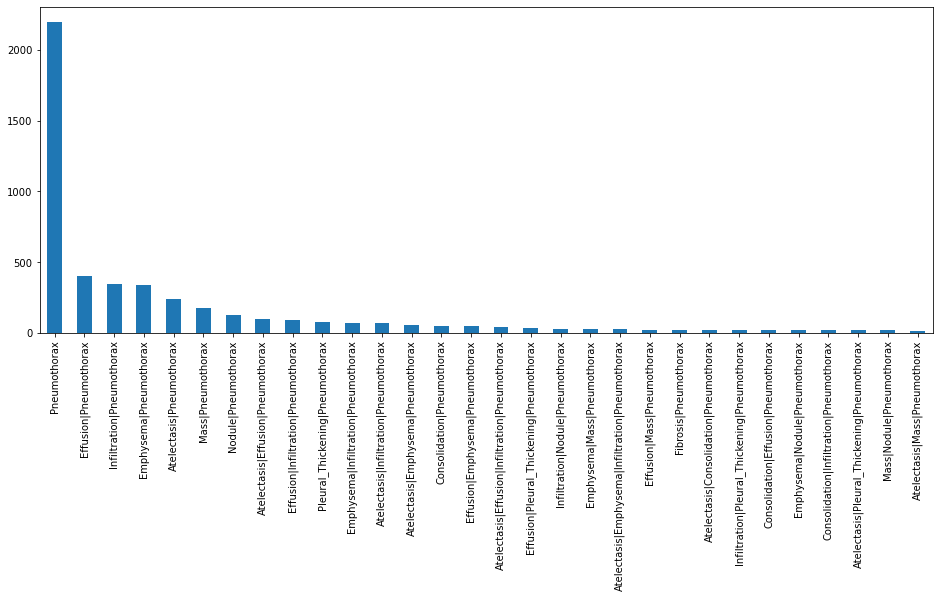

In [6]:
plt.figure(figsize=(16,6))
all_xray_df[all_xray_df.Pneumothorax==1]['finding_labels'].value_counts()[0:30].plot(kind='bar')
pass

## Create training and testing data:

#### let's create the appropriate training and validation sets for a model that we want to train to classify the presence of a **Pneumonia**

In [7]:
train_df, valid_df = skl.train_test_split(all_xray_df, 
                                          test_size = 0.2, 
                                          stratify = all_xray_df['Pneumonia'])

#### Let's see the shape of our dataset

In [8]:
train_df.shape

(89696, 28)

### Verify that train_test_split have the same proportions of Pneumonia in both sets.

In [9]:
train_df['Pneumonia'].sum()/len(train_df)

0.012765340706386016

In [10]:
valid_df['Pneumonia'].sum()/len(valid_df)

0.012754191937210132

### We want our model to be trained on a set that has equal proportions of pneumonia and no pneumonia, so we will discard some data:

In [11]:
p_inds = train_df[train_df.Pneumonia==1].index.tolist()
np_inds=train_df[train_df.Pneumonia==0].index.tolist()

np_sample = sample(np_inds,len(p_inds))
train_df = train_df.loc[p_inds + np_sample]

**Verify the ratio: Here we want to ensure that there is equal distribution which is 50%**

In [12]:
train_df['Pneumonia'].sum()/len(train_df)

0.5

### Similarly for the validation set 

In [13]:
p_inds = valid_df[valid_df.Pneumonia==1].index.tolist()
np_inds = valid_df[valid_df.Pneumonia==0].index.tolist()

# The following code pulls a random sample of non-pneumonia data that's 4 times as big as the pneumonia sample.
np_sample = sample(np_inds,4*len(p_inds))
valid_df = valid_df.loc[p_inds + np_sample]

**Verify the ratio**
- Recall we only want 20% of Pneumonia in the validation data

In [14]:
valid_df['Pneumonia'].sum()/len(valid_df)

0.2

# Now we can begin our model-building & training

**Let's take a look at our images before we proceed**

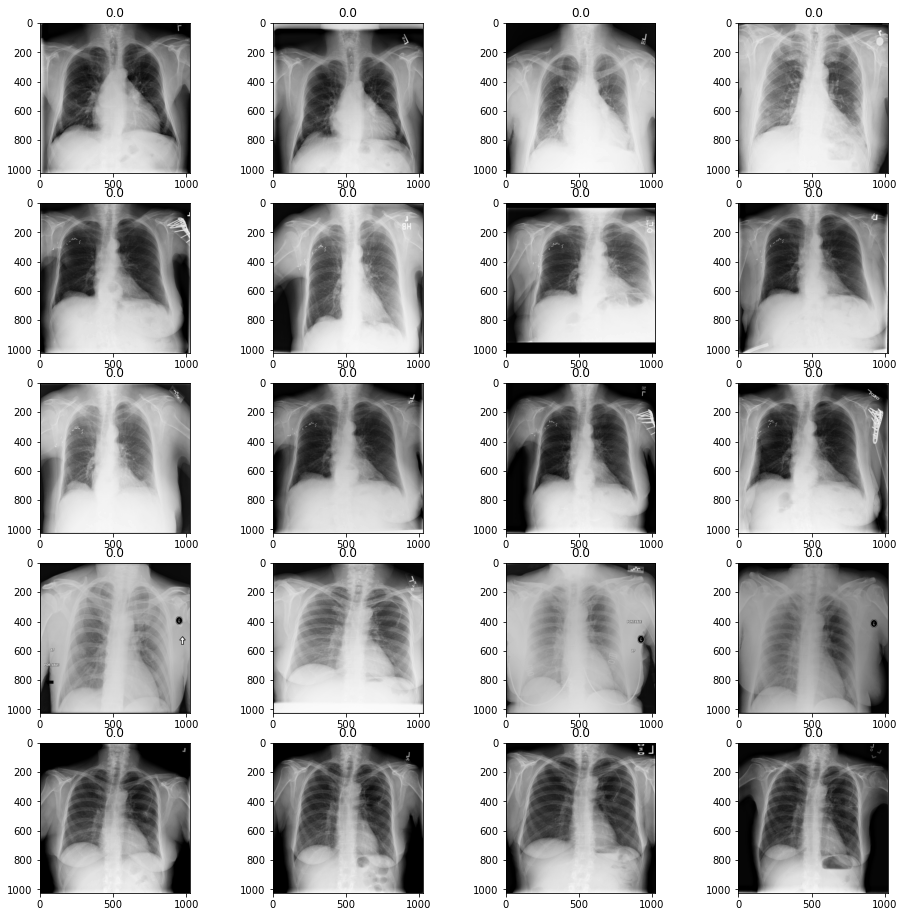

In [23]:
fig, m_axs = plt.subplots(5,4, figsize = (16, 16))
m_axs = m_axs.flatten()
imgs = all_xray_df.path
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.imshow(img,cmap='gray')
    ax.set_title(all_xray_df.iloc[ind]['Pneumonia'])
    ind=ind+1

### Now, let's perform image augmentation
*All images will be rescaled by 1./255*

*Convert Pneumonia data to string and choose image size*

In [15]:
train_df['Pneumonia'] = train_df['Pneumonia'].apply(lambda x:str(x))
valid_df['Pneumonia'] = valid_df['Pneumonia'].apply(lambda x:str(x))

#### Let choose our image size to display

In [16]:
IMG_SIZE = (224, 224)

**Set the best parameters for train set Image data generator**

In [19]:
train_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip=True, 
                              vertical_flip=False, 
                              height_shift_range=0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)

train_gen = train_idg.flow_from_dataframe(dataframe=train_df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'Pneumonia',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 9)

Found 2290 validated image filenames belonging to 2 classes.


**Repeat same on validation set but with only rescale because we do not want to expose our validation data to our traning data**

In [27]:
val_idg = ImageDataGenerator(rescale=1. / 255.0)

val_gen = val_idg.flow_from_dataframe(dataframe=valid_df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'Pneumonia',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 100)

Found 1430 validated image filenames belonging to 2 classes.


#### Let's take a look at our augmented training data  to understanding the extent to which data is being manipulated prior to training, and can be compared with how the raw data look prior to augmentation

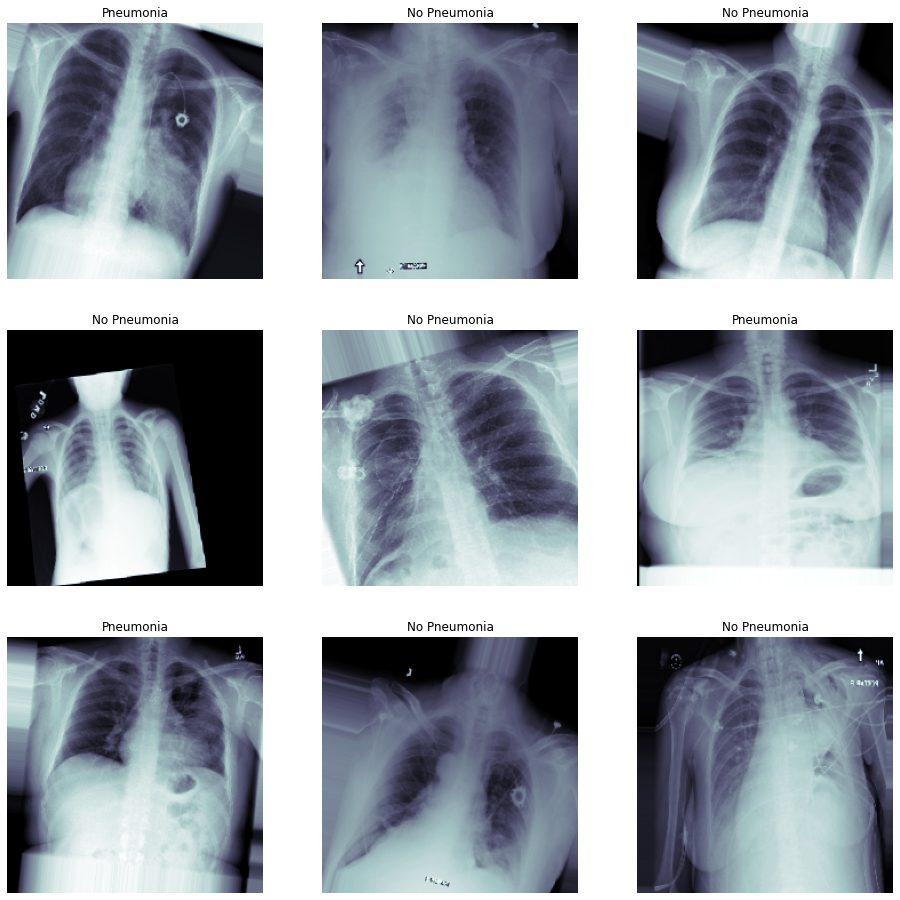

In [28]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(3, 3, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

### Let's Build our model: 

First let's download a VGG16 pre-trained network from Keras for fine-tuning.

In [21]:
model = VGG16(include_top=True, weights='imagenet')
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

**Transfer layer to block5_pool and create a VGG model**

In [22]:
transfer_layer = model.get_layer('block5_pool')

vgg_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)

#### Choose which layers of VGG16 we actually want to fine-tune and freeze all but the last convolutional layer

In [23]:
for layer in vgg_model.layers[0:17]:
    layer.trainable = False

In [24]:
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True


#### Time to proceed with our model with  dropout which may prevent overfitting and improve generalization of unseen ability to unseen data

In [25]:
my_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
my_model.add(vgg_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
my_model.add(Flatten())

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
my_model.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
my_model.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
my_model.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
my_model.add(Dense(512, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
my_model.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
my_model.add(Dense(256, activation='relu'))

# Add a dense (aka. fully-connected) layer.
# Change the activation function to sigmoid 
# so output of the last layer is in the range of [0,1] 
my_model.add(Dense(1, activation='sigmoid'))

#### Set optimizer, loss function, and learning rate

In [26]:
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

#### Compile the model

In [27]:
my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

**This will save the 'best' version of the model by comparing it to previous epochs of training** 
- The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing improvement before quitting

In [28]:
CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC = "auto"
CHOOSE_METRIC_TO_MONITOR_FOR_PERFORMANCE = 'val_loss'
weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path,
                             monitor= CHOOSE_METRIC_TO_MONITOR_FOR_PERFORMANCE, 
                             verbose=1, 
                             save_best_only=True, 
                             mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
                             save_weights_only = True)

early = EarlyStopping(monitor='val_loss', 
                      mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
                      patience=10)

callbacks_list = [checkpoint, early]

##### Pull a single large batch of random validation data for testing after each epoch

In [29]:
valX, valY = val_gen.next()

In [20]:
t_x, t_y = next(train_gen)
print('Train', t_x.min(), t_x.max(), t_x.mean(), t_x.std())

Train 0.0 1.0 0.46913633 0.25548193


### Start training the model

In [30]:
history = my_model.fit_generator(train_gen,validation_data = (valX, valY),
                                 epochs = 20,
                                 callbacks=callbacks_list)

Epoch 1/20
255/255 [==============================] - 69s 270ms/step - loss: 0.7678 - binary_accuracy: 0.5245 - val_loss: 0.6547 - val_binary_accuracy: 0.5400

Epoch 00001: val_loss improved from inf to 0.65472, saving model to xray_class_my_model.best.hdf5
Epoch 2/20
255/255 [==============================] - 61s 238ms/step - loss: 0.7078 - binary_accuracy: 0.5279 - val_loss: 0.6565 - val_binary_accuracy: 0.5600

Epoch 00002: val_loss did not improve from 0.65472
Epoch 3/20
255/255 [==============================] - 62s 242ms/step - loss: 0.6796 - binary_accuracy: 0.5865 - val_loss: 0.6138 - val_binary_accuracy: 0.6000

Epoch 00003: val_loss improved from 0.65472 to 0.61378, saving model to xray_class_my_model.best.hdf5
Epoch 4/20
255/255 [==============================] - 62s 244ms/step - loss: 0.6734 - binary_accuracy: 0.5790 - val_loss: 0.6084 - val_binary_accuracy: 0.6000

Epoch 00004: val_loss improved from 0.61378 to 0.60843, saving model to xray_class_my_model.best.hdf5
Epoch 5

##### After training, make some predictions to assess your model's overall performance 

In [31]:
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

100/100 [==============================] - 4s 41ms/step


#### Plot the history of the model training

In [32]:
def plot_history(history):
    plt.figure(figsize=(30,10))
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

<Figure size 2160x720 with 0 Axes>

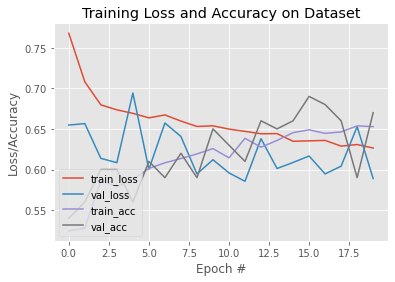

In [33]:
plot_history(history)

#### Pull out Training and Validation Loss for closer study of the performance

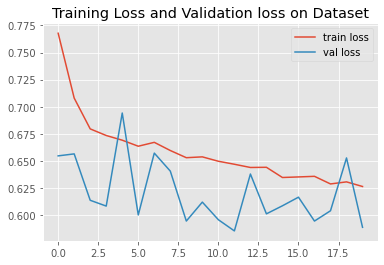

In [34]:
plt.style.use("ggplot")
plt.title("Training Loss and Validation loss on Dataset")
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
pass

**Our train loss made a lot of progress by minimizing loss function, from 0.75, it was able to minimize loss to 0.62. Also, the model minimized val loss and stopped learning at 17 epoch.**

## Evaluate model

### A Plot of F1 vs Thresholds

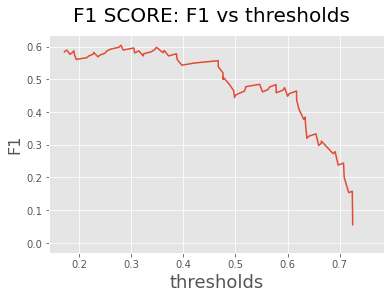

In [149]:
fig = plt.figure()
plt.style.use("ggplot")
plt.plot(thresholds_1,F1_1[1:])
fig.suptitle("F1 SCORE: F1 vs thresholds", fontsize=20)
plt.xlabel("thresholds", fontsize=18)
plt.ylabel("F1", fontsize=16)
fig.savefig('F1.jpg')
pass

### Precision/Recall curve

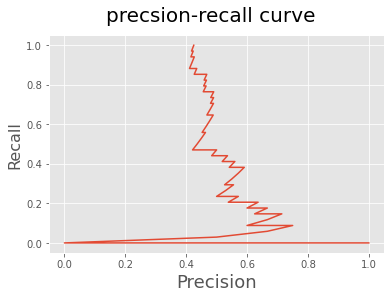

In [147]:
fig = plt.figure()
plt.style.use("ggplot")
plt.plot(precision,recall)
fig.suptitle("precsion-recall curve", fontsize=20)
plt.xlabel("Precision", fontsize=18)
plt.ylabel("Recall", fontsize=16)
pass

## AOC Plot

In [105]:
def plot_auc(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')

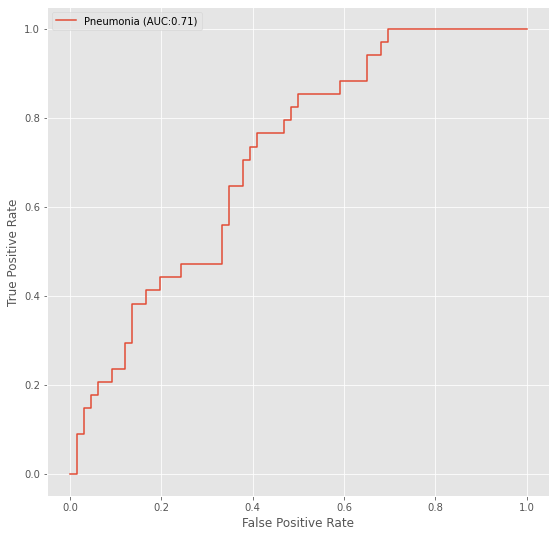

In [106]:
plot_auc(valY,pred_Y)

In [150]:
precision, recall, thresholds = precision_recall_curve(valY, pred_Y)
F1 = 2 * (precision * recall) / (precision + recall)
print('ROC AUC:', roc_auc_score(valY,pred_Y))
print('Best Precision:', precision[np.argmax(recall)])
print('Best threshold: ', thresholds[np.argmax(F1)])

ROC AUC: 0.7090017825311943
Best Precision: 0.425
Best threshold:  0.75566494


From our plot the precision-recall curve is 0.425 this shows the tradeoff between precision and recall for different thresholds. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate.Best thresholds for F1 is at 0.75566494 and ROC AUC is at 0.71 as shown in the curve.

**Let's look at some examples of true vs. predicted with our best model:** 

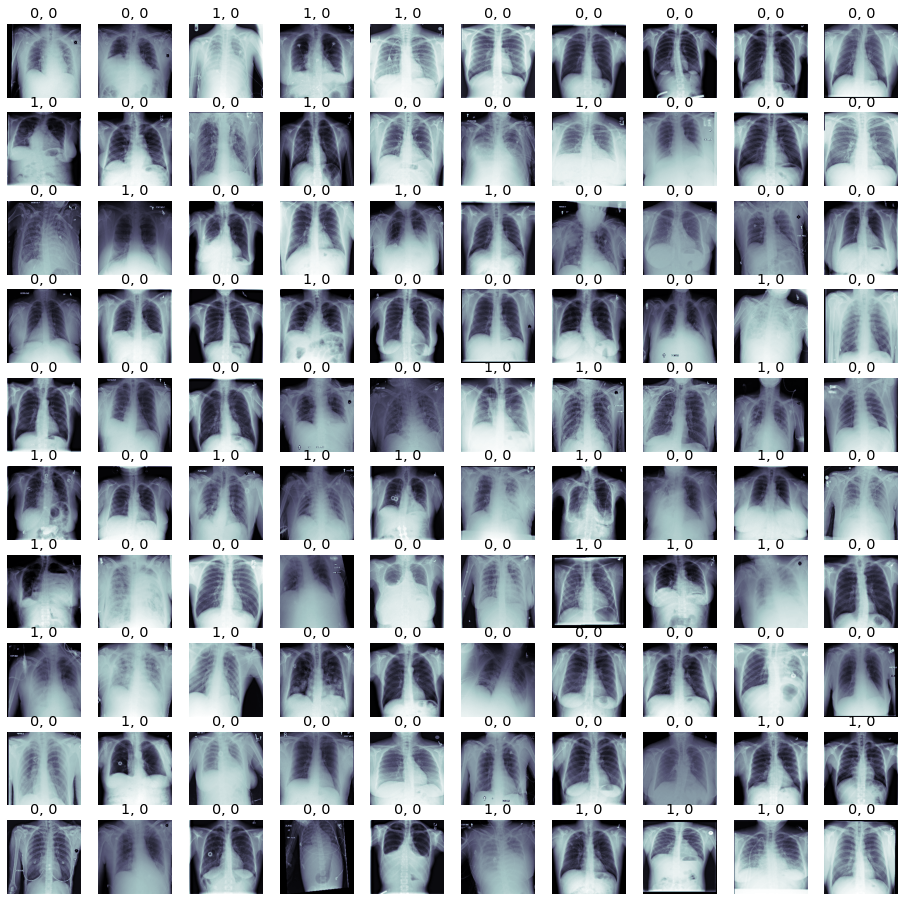

In [107]:
THRESHOLD= 0.75566494
fig, m_axs = plt.subplots(10,10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

### Experiment with lower thresholds 

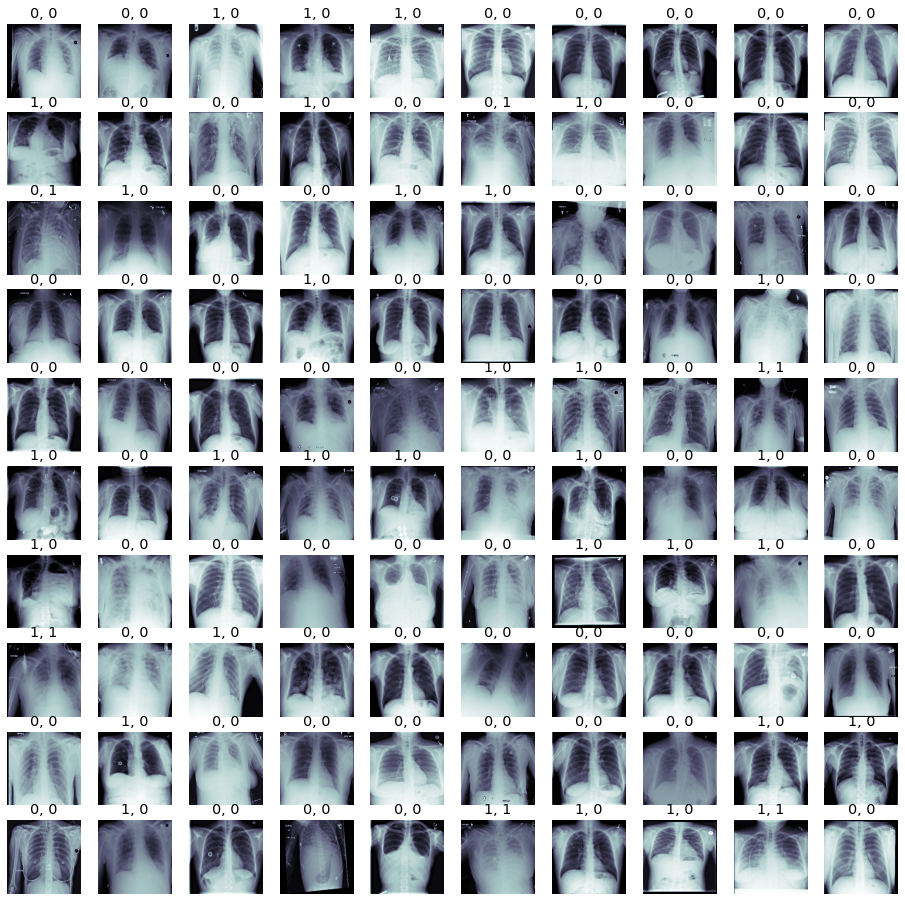

In [151]:
THRESHOLD= 0.7090017825311943
fig, m_axs = plt.subplots(10,10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

- It is observed that by using a lower thresholds of 0.71, were able to predict more pneumonia as compared to 0.75. In other to minimize loss, a good choice would go for higher thresholds.

### Just save model architecture to a .json:

In [40]:
model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)

### Next, proceed to  Inference notebook for findings and conclusions .

In [ ]:
def preprocess_image(img,img_mean,img_std,img_size):  
    img=img/255.0  
    proc_img=(img-img_mean)/img_std 
    # Your code to resize your image to (224,224,3)
    # One proposal: 
    proc_img = np.zeros((224,224,3))
    # to RGB (input of the first layer)
    proc_img[:, :, 0] = grey_image
    proc_img[:, :, 1] = grey_image
    proc_img[:, :, 2] = grey_image
    proc_img = np.resize(proc_img,(1,224,224,3))
    return proc_img 


In [ ]:
def predict_image(model, img, thresh): 
  
    result = model.predict(img)  
    predict=result[0]
    prediction='No pneumonia'
    if(predict>thresh):
        prediction='Pneumonia'
        
    return prediction 